In [2]:
import tables_io
import numpy as np
import matplotlib.pyplot as plt
import pyccl as ccl
from rail.raruma import utility_functions as raruma_util
from rail.raruma import plotting_functions as raruma_plot
from rail.raruma import admixture_functions as raruma_admix
from rail.raruma import wrapper_classes as raruma_wrap
from scipy.stats import sigmaclip
from astropy.stats import biweight_location, biweight_scale


In [3]:
import os

# pz_dir = '/global/cfs/cdirs/lsst/groups/PZ/DP1'  
# if that fails you can use this
# pz_dir = '/global/u2/e/echarles/dx'
#pz_dir = '/Users/echarles/pz'

# use user home directory
#pz_dir = os.path.expanduser('~')

# use user home directory plus additional folder
#pz_dir = os.path.expanduser('~') + '/pz'
pz_dir = os.path.expanduser('~') + '/dev'

print("pz_dir:",pz_dir)

pz_dir: /home/phoenix/dev


In [4]:
train = tables_io.read(f"{pz_dir}/data/train/dp1_ecdfs_matched_specgold_train.hdf5")
test = tables_io.read(f"{pz_dir}/data/test/dp1_ecdfs_matched_specgold_test.hdf5")
#d.keys()
#train = tables_io.sliceObj(d, slice(0, -1, 10))
#test = tables_io.sliceObj(d, slice(1, -1, 10))

# uncomment if model files are located alongside data folder
model_file_knn = pz_dir + '/model_inform_knn.pkl'
model_file_bpz = pz_dir + '/model_inform_bpz.pkl'
model_file_fzb = pz_dir + '/model_inform_fzboost.pkl'
model_file_gpz = pz_dir + '/model_inform_gpz.pkl'

# uncomment if model files are located in same folder as the Jupyter notebook
#model_file_knn = './model_inform_knn.pkl'
#model_file_bpz = './model_inform_bpz.pkl'
#model_file_fzb = './model_inform_fzboost.pkl'
#model_file_gpz = './model_inform_gpz.pkl'

In [5]:
from rail.estimation.algos.k_nearneigh import KNearNeighEstimator
from rail.estimation.algos.bpz_lite import BPZliteEstimator
from rail.estimation.algos.flexzboost import FlexZBoostEstimator
from rail.estimation.algos.gpz import GPzEstimator
from rail.utils.catalog_utils import RubinCatalogConfig
RubinCatalogConfig.apply(RubinCatalogConfig.tag)
band_names = raruma_util.make_band_names('LSST_obs_{band}', 'ugrizy')
error_band_names = raruma_util.make_band_names('LSST_obs_{band}_err', 'ugrizy')

In [6]:
train_features = raruma_util.get_band_values(train, '{band}_gaap1p0Mag', 'ugrizy')
error_bands = raruma_util.get_band_values(train, '{band}_gaap1p0MagErr', 'ugrizy')

In [7]:
knn = KNearNeighEstimator.make_stage(name='knn', model=model_file_knn, input='dummy.in', output_mode='return', nzbins=3001)
knn.stage_columns = knn.config.bands
knn_w = raruma_wrap.CatEstimatorWrapper(knn, band_names)

Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn


In [8]:
noise_grid = np.logspace(-4, 0, 17)

In [9]:
# Uncertainty extraction: calculates standard deviation of redshift PDFs
def calc_std(qp_dstn, grid):
    pdfs = qp_dstn.pdf(grid)  # Get PDF values on grid
    norms = pdfs.sum(axis=1)  # Normalize
    means = np.sum(pdfs * grid, axis=1) / norms  # Calculate mean redshift
    diffs = (np.expand_dims(grid, -1) - means).T  # Distance from mean
    wt_diffs = diffs * diffs * pdfs  # Weighted squared differences
    stds = np.sqrt((wt_diffs).sum(axis=1)/norms)  # Standard deviation
    return np.expand_dims(stds, -1)

# Grid for uncertainty calculations
z_grid = np.linspace(0., 4., 401)

In [43]:
from rail.core.stage import RailStage

def doit(wrapper, nclip=3):
    the_dict = {}
    inputs = np.hstack([train_features, error_bands])
    est_orig = wrapper(inputs.T)

    # Record baseline uncertainty (before any noise)
    RailStage.data_store.clear() # Clear data store before estimate
    wrapper._estimator.config.output_mode = 'default' # Enable file writing
    train_for_knn = {name: train_features[:, i] for i, name in enumerate(band_names)} # Create dict with LSST_obs_* column names
    baseline_handle = wrapper._estimator.estimate(train_for_knn) # Generate PDFs and save to file
    baseline_ensemble = qp.read(baseline_handle.path) # Read PDFs back from file
    uncertainty_base = calc_std(baseline_ensemble, z_grid) # Record uncertainty from PDFs
    
    means = []
    stds = []
    outlier_fracs = []
    uncertainty_ratios = []
    
    for noise in noise_grid:
        noisy_mags = raruma_admix.gaussian_noise(train_features, noise_levels=noise*np.ones(6)).T
        inputs = np.hstack([noisy_mags, error_bands])
        ad_vals = wrapper(inputs.T)

        # Record uncertainty with noise and calculate ratio to baseline
        RailStage.data_store.clear() # Clear data store
        train_noisy = {name: noisy_mags[:, i] for i, name in enumerate(band_names)} # Create dict with LSST_obs_* column names
        noise_handle = wrapper._estimator.estimate(train_noisy) # Generate PDFs and save to file
        noise_ensemble = qp.read(noise_handle.path) # Read PDFs from file
        uncertainty_noise = calc_std(noise_ensemble, z_grid) # Record uncertainty from PDFs
        uncertainty_ratios.append(np.median(uncertainty_noise / uncertainty_base)) # >1 means uncertainty increased
        
        deltas = (ad_vals - est_orig)/(1 + est_orig)
        subset_clip, _, _ = sigmaclip(deltas, low=3, high=3)
        for _j in range(nclip):
            subset_clip, _, _ = sigmaclip(subset_clip, low=3, high=3)

        the_dict[noise] = deltas
        outliers = (np.fabs(deltas) > 0.15).sum() / float(deltas.size)
        outlier_fracs.append(outliers)
        #means.append(deltas.mean())
        #stds.append(deltas.std())
        means.append(biweight_location(subset_clip))
        stds.append(biweight_scale(subset_clip))

    _ = plt.plot(noise_grid, means, label=r"mean $\delta z$")
    _ = plt.plot(noise_grid, stds, label=r"RMS $\delta z$")
    _ = plt.plot(noise_grid, outlier_fracs, label=r"f $\delta z > 0.15$")
    _ = plt.plot(noise_grid, uncertainty_ratios, label="Uncertainty ratio")  # Plot the uncertainty ratios (pre- and post-noise)
    _ = plt.xscale('log')
    _ = plt.legend()
    _ = plt.xlabel("Noise [mag]")
    _ = plt.ylabel(r"$\delta z$")

Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Inserting handle into data store.  input: dummy.in, knn
Inserting handle into data store.  model: /home/phoenix/dev/model_inform_knn.pkl, knn
Process 0 running estimator on chunk 0 - 4,803
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hdf5, knn
Process 0 estimating PZ PDF for rows 0 - 4,803
Inserting handle into data store.  output_knn: inprogress_output_knn.hd

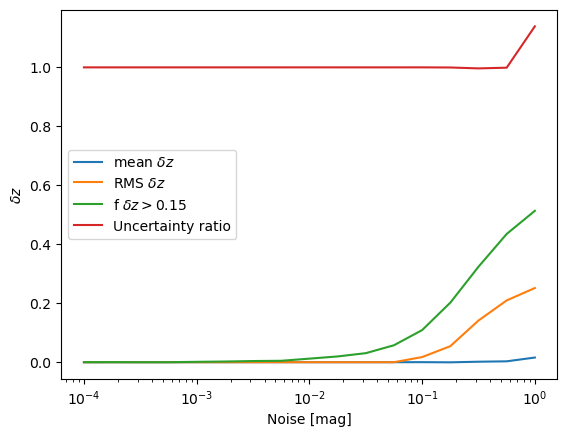

In [42]:
doit(knn_w)